<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/ALCF/AD_LTEM_PyTorch_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from routines.microscopes_fwd import *
from routines.img_helper import *

import torch
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
import numpy as np
import tifffile as tif
from matplotlib import pyplot, colors
import sys, time
from scipy import ndimage
from scipy.fftpack import *
import gdown
from scipy.signal import fftconvolve
import fabio
import scipy.constants as physcon
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# will be available once we get the approval
# sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla M10


In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import Dataset

In [38]:
import sys
import os
from PIL import Image
import math
from numpy.lib import scimath
from numpy import emath

In [ ]:
image = Image.open('/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_25/TIE/usaf_nano/aligned_imgj/unflip/full_aligned_cropped.tif')
print(f"Original size : {image.size}") # 5464x3640

quad1_resized = image.resize((512, 512))
quad1_resized.save('/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_25/TIE/bars_circles_lg/aligned_imgj/unflip/sunset.tiff')

In [50]:
#  !gdown "http://drive.google.com/uc?id=1S6RFU3eTiHVM6wN5YfS7VBk6NzmATi54"
expdata = fabio.open("/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_25/TIE/hex_sm_nano/aligned_imgj/unflip/full_aligned_cropped.tif")
# fabio.open("/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_18/TIE/usaf_micro/aligned_imgj/unflip/aligned_usaf_micro_32.tif")

## Set up the Object (Sample)

In [52]:
# Dimensions of object:
Nz = 5#7 #9 #7 #15 number of images in stack
Ny = 2728#3600 #2970 #4096 #2400   # length of y-axis
Nx = 2728#3600 #2970 #4096 #2400   # length of x-axis
del_px = 0.883789063#6.940917969 #2.314453125  # nm/pixel
print("del_px:", del_px)

A_samples = np.zeros((Nz, Ny, Nx))
print("A_samples is of type:", type(A_samples))
print("A_samples is of shape:", A_samples.shape)    # verify the array


for ii in range(Nz):
  A_samples[ii] =  expdata.getframe(ii).data[:,:]#[1185:(1185+1350), 0:1350]

# np.save(file="/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_25/TIE/hex_sm_nano/aligned_imgj/images/RMAD/hex_sm_nano_A_samples.npy",
#         arr=A_samples,
#         allow_pickle=False
#         )


A_samples = np.sqrt(A_samples) #np.emath.sqrt(A_samples) #np.sqrt(A_samples)

# normalize to the amplitude of the sample's experimental values
A_samples/=A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis] 

# defocus = np.array([-2396160.0, -1234944.0, 0.0, 1234944.0, 2396160.0])

# f, ax = pyplot.subplots(ncols=3, figsize = (14,8))
# ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[2].min(), A_samples[2].max()))
# ax[0].set_title("{0} nm".format(defocus[0]))
# ax[1].imshow(A_samples[2], cmap='viridis', norm=colors.Normalize(A_samples[2].min(), A_samples[2].max()))
# ax[1].set_title("{0} nm".format(defocus[2]))
# ax[2].imshow(A_samples[-1], cmap='viridis', norm=colors.Normalize(A_samples[2].min(), A_samples[2].max()))
# ax[2].set_title("{0} nm".format(defocus[-1]));

del_px: 0.883789063
A_samples is of type: <class 'numpy.ndarray'>
A_samples is of shape: (5, 2728, 2728)


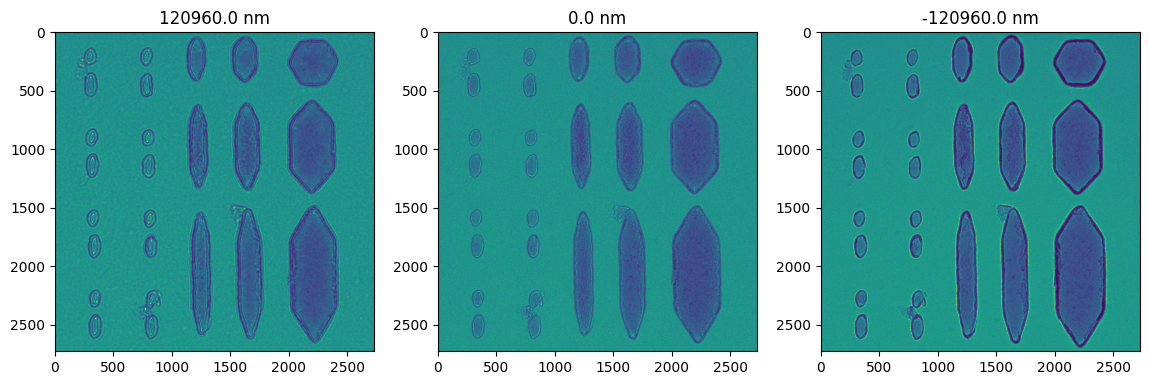

In [53]:
# usaf_nano
# defocus = np.array([2658816.0,
#                     1603584.0,
#                     801792.0,
#                     400896.0,
#                     0.0,
#                     -400896.0,
#                     -801792.0,
#                     -1603584.0,
#                     -2658816.0,
#                     ])

# bars_circs_lg_micro
# defocus = np.array([1216512.0, 811008.0, 405504.0, 0.0, -405504.0, -811008.0, -1216512.0])

# bars_circs_md_micro
# defocus = np.array([2405376.0, 1285632.0, 640512.0, 322560.0, 161280.0, 82944.0, 41472.0, 0.0, -41472.0, -82944.0, -161280.0, -322560.0, -640512.0, -1285632.0, -2405376.0])

# hexs_lg
# defocus = np.array([2396160.0, 1603584.0, 811008.0, 405504.0, 0.0, -405504.0, -811008.0, -1603584.0, -2396160.0])

# hexs_md
# defocus = np.array([640512.0, 322560.0, 161280.0, 82944.0, 41472.0, 0.0, -41472.0, -82944.0, -161280.0, -322560.0, -640512.0])

# hexs_sm_nano
defocus = np.array([120960.0, 40320.0, 0.0, -40320.0, -120960.0])

# usaf_micro
# defocus = np.array([1234944.0, 608256.0, 313344.0, 0.0, -313344.0, -608256.0, -1234944.0])

f, ax = pyplot.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[2].min(), A_samples[2].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[2], cmap='viridis', norm=colors.Normalize(A_samples[2].min(), A_samples[2].max()))
ax[1].set_title("{0} nm".format(defocus[2]))
ax[2].imshow(A_samples[-1], cmap='viridis', norm=colors.Normalize(A_samples[2].min(), A_samples[2].max()))
ax[2].set_title("{0} nm".format(defocus[-1]));

In [54]:
# rewriting the microscope transfer function with tensorflow
import scipy.constants as physcon

# Dimensions of the dataset are reciprocal space (dim) dimensions
[dim,dim] = A_samples[2].shape
# Dimensions of real space (d2) dimensions
d2 = dim/2
print("RECIPROCAL space is:", dim, "and REAL space is:", d2)

line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = torch.tensor(np.sqrt(X**2 + Y**2) / float(dim), 
                  dtype=torch.float32, 
                  requires_grad=True, 
                  device=device)

# del_px = del_px #nm/px

# E = 200.0e3
# Cs=1.0e6
# Cc=5.0e6
# Ca=0.0e6
# phi_a=0
# def_spr = 500

# epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
# lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
# gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
# sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

# lam = lam / del_px
# cs = Cs / del_px
# ca = Ca / del_px
# phi = 0
# spread = def_spr / del_px

# scale1 = 1
# scale2 = 100

# def getTF(defoc, theta_c):

#   def_val = defoc * scale1 / del_px

#   theta_c = torch.pow(10, theta_c/scale2)

#   p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
#   p2 = np.pi * cs * lam**3 * 0.5 
#   p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
#   p4 = (np.pi * lam * spread)**2
#   p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
#   p6 = cs * lam**3   
#   p7 = def_val * lam  # a tensor
 
#   u = 1.0 + p3 * qq**2 
#   chiq = -p1 * qq**2 + p2 * qq**4  
#   es_arg = 1.0/(2.0*u) * p4 * qq**4   
#   et_arg = torch.multiply(1.0/u, torch.multiply(p5, (p6 * qq**3 - torch.multiply(p7,qq) )**2 ) )  # a tensor

#   dampenv = torch.exp(es_arg-et_arg)   # a tensor
#   transfer_function = torch.fft.fftshift(torch.multiply(torch.complex(torch.cos(chiq),-torch.sin(chiq)), dampenv), dim=(1,2))
  
#   return transfer_function

RECIPROCAL space is: 2728 and REAL space is: 1364.0


In [55]:
del_px = del_px #nm/px

E = 200.0e3 # kV
Cs = 1.0e6    
Cc = 5.0e6
Ca = 0.0e6
phi_a = 0.0
def_spr = 120

epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

scale1 = 1
scale2 = 100

In [56]:
lam = lam / del_px
cs = Cs / del_px
ca = Ca / del_px
phi = 0
spread = def_spr / del_px

In [57]:
def getTF(defoc, theta_c):

  def_val = defoc * scale1 / del_px

  theta_c = torch.pow(10, theta_c/scale2)

  p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
  p2 = np.pi * cs * lam**3 * 0.5 
  p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
  p4 = (np.pi * lam * spread)**2
  p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
  p6 = cs * lam**3   
  p7 = def_val * lam  # a tensor
 
  u = 1.0 + p3 * qq**2 
  chiq = -p1 * qq**2 + p2 * qq**4  
  es_arg = 1.0/(2.0*u) * p4 * qq**4   
  et_arg = torch.multiply(1.0/u, torch.multiply(p5, (p6 * qq**3 - torch.multiply(p7,qq) )**2 ) )  # a tensor

  dampenv = torch.exp(es_arg-et_arg)   # a tensor
  transfer_function = torch.fft.fftshift(torch.multiply(torch.complex(torch.cos(chiq),-torch.sin(chiq)), dampenv), dim=(1,2))
  
  return transfer_function

In [58]:
def compute_loss():
  tf_obj = guess_amplitude * torch.exp(1j*guess_phase)
  cal_data = torch.fft.ifft2(torch.fft.fft2(tf_obj)*getTF(defoc, theta_c))
  cal_data = torch.abs(cal_data)
  cal_data /= torch.mean(cal_data, dim=(1,2), keepdims=True)

  return torch.mean((cal_data - exp_data)**2)

In [59]:
def training_loop(optimizer, n=10000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = compute_loss()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.cpu().detach().numpy())  
        if i>0 and not i%10000:
          print(loss, theta_c)
    return losses

## BE SURE TO MODIFY GUESS AMPLITUDE AND GUESS PHASE in variable A_samples[n = "IF Image"]

In [60]:
## BE SURE TO MODIFY GUESS AMPLITUDE AND GUESS PHASE in variable A_samples[n = "IF Image"]

selection = [0, 1, 2, 3, 4]#, 5, 6]
# selection = [0, 1, 2, 3, 4, 5, 6, -6, -5, -4, -3, -2, -1]
print("chosen defocus (mm): ", defocus[selection]/1e6)

exp_data = torch.from_numpy(A_samples[selection].astype(np.float32)).to(device)

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = torch.tensor(denoise_tv_chambolle(A_samples[2], 
                                                    weight=0.025, 
                                                    channel_axis=False), 
                                dtype=torch.float32, 
                                requires_grad=False, 
                                device=device)
# initialize the phase as 0.5 everywhere

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_phase = torch.tensor(np.zeros(A_samples[2].shape)+0.5, 
                           dtype=torch.float32, 
                           requires_grad=True, 
                           device=device) 
print(guess_phase.type(), guess_phase.dtype)

defoc = torch.tensor(defocus[selection][:, np.newaxis, np.newaxis]/scale1, 
                     dtype=torch.float32, 
                     requires_grad=False, 
                     device=device)
theta_c = torch.tensor(-500, dtype=torch.float32, requires_grad=False, device=device) 

opt = torch.optim.Adam([guess_phase], lr=.025)

chosen defocus (mm):  [ 0.12096  0.04032  0.      -0.04032 -0.12096]
torch.cuda.FloatTensor torch.float32


In [61]:
losses = training_loop(opt, n=1000)
# losses = training_loop(opt, n=200000)

RuntimeError: CUDA out of memory. Tried to allocate 142.00 MiB (GPU 0; 7.94 GiB total capacity; 7.19 GiB already allocated; 40.19 MiB free; 7.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
f, ax = pyplot.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(losses)
ax[0].set_title("err")
ax[1].plot(losses)
ax[1].set_title("err");

In [ ]:
?losses

In [ ]:
np.save(file="/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_25/TIE/hex_sm_nano/aligned_imgj/images/RMAD/hex_sm_nano_full_1000_11m43s.npy",
        arr=losses,
        allow_pickle=False
        )

In [ ]:
result_phase = guess_phase.cpu().detach().numpy()
result_phase -= result_phase.mean()

In [ ]:
def show_im(
    image,
    title=None,
    simple=False,
    origin="upper",
    cbar=True,
    cbar_title="",
    scale=None,
    **kwargs,
):
    """Display an image on a new axis.

    Takes a 2D array and displays the image in grayscale with optional title on
    a new axis. In general it's nice to have things on their own axes, but if
    too many are open it's a good idea to close with plt.close('all').

    Args:
        image (2D array): Image to be displayed.
        title (str): (`optional`) Title of plot.
        simple (bool): (`optional`) Default output or additional labels.

            - True, will just show image.
            - False, (default) will show a colorbar with axes labels, and will adjust the
              contrast range for images with a very small range of values (<1e-12).

        origin (str): (`optional`) Control image orientation.

            - 'upper': (default) (0,0) in upper left corner, y-axis goes down.
            - 'lower': (0,0) in lower left corner, y-axis goes up.

        cbar (bool): (`optional`) Choose to display the colorbar or not. Only matters when
            simple = False.
        cbar_title (str): (`optional`) Title attached to the colorbar (indicating the
            units or significance of the values).
        scale (float): Scale of image in nm/pixel. Axis markers will be given in
            units of nanometers.

    Returns:
        None
    """
    fig, ax = plt.subplots()
    if not simple and np.max(image) - np.min(image) < 1e-12:
        # adjust coontrast range
        vmin = np.min(image) - 1e-12
        vmax = np.max(image) + 1e-12
        im = ax.matshow(image, cmap="gray", origin=origin, vmin=vmin, vmax=vmax)
    else:
        im = ax.matshow(image, cmap="gray", origin=origin, **kwargs)

    if title is not None:
        ax.set_title(str(title), pad=0)

    if simple:
        plt.axis("off")
    else:
        plt.tick_params(axis="x", top=False)
        ax.xaxis.tick_bottom()
        ax.tick_params(direction="in")
        if scale is None:
            ticks_label = "pixels"
        else:

            def mjrFormatter(x, pos):
                return f"{scale*x:.3g}"

            fov = scale * max(image.shape[0], image.shape[1])

            if fov < 4e3:  # if fov < 4um use nm scale
                ticks_label = " nm "
            elif fov > 4e6:  # if fov > 4mm use m scale
                ticks_label = "  m  "
                scale /= 1e9
            else:  # if fov between the two, use um
                ticks_label = " $\mu$m "
                scale /= 1e3

            ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
            ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))

        if origin == "lower":
            ax.text(y=0, x=0, s=ticks_label, rotation=-45, va="top", ha="right")
        elif origin == "upper":  # keep label in lower left corner
            ax.text(
                y=image.shape[0], x=0, s=ticks_label, rotation=-45, va="top", ha="right"
            )

        if cbar:
            plt.colorbar(im, ax=ax, pad=0.02, format="%.2g", label=str(cbar_title))

    plt.show()
    return

In [ ]:
show_im(result_phase)
from tifffile import imwrite
import numpy as np

imwrite("/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_25/TIE/hex_sm_nano/aligned_imgj/images/RMAD/hex_sm_nano_1000_RAW.tif", result_phase)
# imwrite("/home/ktrujillo/Lorentz/Kayna/Simulations/Mumax3/2023_04_26/results_nano.tiff", result_phase)
# imwrite("/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_18/TIE/usaf_/aligned_imgj/images/RMAD/usaf_nano_AD_RAW_200000.tiff", result_phase)

In [ ]:
from routines.img_helper import *
p = result_phase
fftp = get_fft(p)
del_px = del_px
print(del_px)

filter_lf = None #2500 # nm
filter_hf = 250 # 2500 # nm

dim_y, dim_x = p.shape

x_sampling = y_sampling = 1 / del_px  # [pixels/nm]
u_max = x_sampling / 2
v_max = y_sampling / 2
u_axis_vec = np.linspace(-u_max / 2, u_max / 2, dim_x)
v_axis_vec = np.linspace(-v_max / 2, v_max / 2, dim_y)
u_mat, v_mat = np.meshgrid(u_axis_vec, v_axis_vec)
r = np.sqrt(u_mat**2 + v_mat**2)  # nm

if filter_lf is not None:
    inverse_gauss_filter = 1 - np.exp(-1 * (r * filter_lf) ** 2)
else:
    inverse_gauss_filter = np.ones_like(r)
if filter_hf is not None:
    gauss_filter = np.exp(-1 * (r * filter_hf) ** 2)
else:
    gauss_filter = np.ones_like(r)
bp_filter = inverse_gauss_filter * gauss_filter

bp_fftp = fftp*bp_filter
kp = get_ifft(bp_fftp).real

show_im(kp, scale=del_px)

In [ ]:
# !gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"

# from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = pyplot.subplots(ncols=2, 
                        figsize = (14,8))

ax[0].imshow(kp, #result_phase, 
             interpolation='none', 
             cmap='viridis')
ax[0].set_title("phase")

t2 = np.copy(kp) #result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),
                           sigma=10,
                           order=0)

gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)

rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)

ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), 
             cmap='gray', 
             alpha=0.1, 
             vmin=-1, 
             vmax=1)
ax[1].set_title("gradient");

## Import RAW DATA Individually

In [ ]:
from skimage import io
p = io.imread("/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_18/TIE/usaf_micro/aligned_imgj/images/RMAD/usaf_micro_AD_RAW.tiff")

show_im(p)
plt.imshow(p, cmap="gray")
